# 02 — Build Final Dataset for Conditional GAN

В этом ноутбуке мы готовим финальный датасет для обучения генеративной модели (Conditional DCGAN) для **Hero Portrait Generator**.

## Цели ноутбука

1. Загрузить финальный CSV с героями (`sprites_final.csv`).
2. Очистить и нормализовать пути к изображениям (используем только относительные пути).
3. Подготовить категориальные признаки:
   - `gender`
   - `hero_class`
   - `palette`
4. Выполнить **train/val split** на уровне `group_id`, чтобы разные варианты одного героя не попадали в разные выборки.
5. Реализовать `HeroPortraitDataset` на PyTorch:
   - загрузка и преобразование изображений;
   - формирование условного вектора (one-hot по `gender`, `hero_class`, `palette`).
6. Собрать `DataLoader` для train/val и проверить, что:
   - изображения корректно читаются;
   - размерности условного вектора соответствуют ожиданиям;
   - можно визуализировать один батч.

Итогом ноутбука станет готовый пайплайн данных для последующего обучния Conditional GAN.


In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision.transforms as T
import torchvision.utils as vutils

from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [8]:
PROJECT_ROOT = Path(r"D:\ML\LS\Deep_learning\GAN\hero_portrait_generator")
DATA_DIR = PROJECT_ROOT / "data"
IMG_DIR = PROJECT_ROOT / "train_images"

CSV_PATH = DATA_DIR / "sprites_final.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("IMG_DIR exists:", IMG_DIR.exists())
print("CSV_PATH exists:", CSV_PATH.exists())

PROJECT_ROOT: D:\ML\LS\Deep_learning\GAN\hero_portrait_generator
DATA_DIR: D:\ML\LS\Deep_learning\GAN\hero_portrait_generator\data
IMG_DIR exists: True
CSV_PATH exists: True


## Загрузка финального CSV и нормализация путей

Мы используем `sprites_final.csv` как основную таблицу. 
Столбец `path` в исходном файле может содержать абсолютные пути — в рамках проекта нам удобнее 
использовать только `filename` и относительный `IMG_DR`.


In [10]:
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()

Shape: (7596, 8)


,filename,path,idx,silhouette_hash,group_id,gender,hero_class,palette
0,image_0_017767286f7f40fdac605acf20e0abd0.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,0,eec6bb950739fea09983e1f52b0cd4e3,0,masculine,knight,warm
1,image_0_0c675f243c4144d98e5d21061d661911.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,0,e87042f6b71065c219f8456ec2d18732,1,feminine,cavalry,dark
2,image_0_1c6697f5b9684e28b67d9e1f36c20e2a.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,0,c1012a17d3ed53d968679e18a1729120,2,masculine,warrior,dark
3,image_0_1ed2ac7ca5e44321ae1dbad2a4c523fc.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,0,3d1c8e4373c5622762aa9b59c741a30f,3,masculine,cavalry,dark
4,image_0_2630d288f1c540e19246aff50a66625e.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,0,c6a807ea2c297b40193171d74ce4b45b,4,feminine,warrior,dark


In [11]:
expected_cols = {
    "filename", "path", "idx", "silhouette_hash",
    "group_id", "gender", "hero_class", "palette"
}
print("Columns:", df.columns.tolist())
missing = expected_cols - set(df.columns)
if missing:
    print("Missing columns:", missing)
else:
    print("All expected columns are present.")

Columns: ['filename', 'path', 'idx', 'silhouette_hash', 'group_id', 'gender', 'hero_class', 'palette']
All expected columns are present.


In [12]:
# Перестраиваем путь на основе filename и IMG_DIR
df["rel_path"] = df["filename"].apply(lambda name: str((IMG_DIR / name).relative_to(PROJECT_ROOT)))

df[["filename", "path", "rel_path"]].head()

,filename,path,rel_path
0,image_0_017767286f7f40fdac605acf20e0abd0.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,train_images\image_0_017767286f7f40fdac605acf2...
1,image_0_0c675f243c4144d98e5d21061d661911.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,train_images\image_0_0c675f243c4144d98e5d21061...
2,image_0_1c6697f5b9684e28b67d9e1f36c20e2a.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,train_images\image_0_1c6697f5b9684e28b67d9e1f3...
3,image_0_1ed2ac7ca5e44321ae1dbad2a4c523fc.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,train_images\image_0_1ed2ac7ca5e44321ae1dbad2a...
4,image_0_2630d288f1c540e19246aff50a66625e.png,D:\ML\LS\Deep_learning\GAN\hero_portrait_gener...,train_images\image_0_2630d288f1c540e19246aff50...


## Быстрая проверка данных

Смотрим, есть ли пропуски, и какие уникальные значения у категориальных признако.


In [13]:
print(df.isna().sum())

filename           0
path               0
idx                0
silhouette_hash    0
group_id           0
gender             0
hero_class         0
palette            0
rel_path           0
dtype: int64


In [14]:
print("gender:", df["gender"].unique())
print("hero_class:", df["hero_class"].unique())
print("palette:", df["palette"].unique())

gender: ['masculine' 'feminine']
hero_class: ['knight' 'cavalry' 'warrior' 'barbarian' 'mage' 'rogue' 'cleric' 'ranger'
 'bard']
palette: ['warm' 'dark' 'neutral' 'cool' 'muted']


## Кодирование категориальных признаков

Для Conditional GAN нам нужны числовые индексы и one-hot представления 
для трёх типов меток: `gender`, `hero_class`, `palette`.

In [15]:
def build_mapping(series):
    classes = sorted(series.unique().tolist())
    mapping = {cls: i for i, cls in enumerate(classes)}
    return mapping, classes

gender_to_idx, gender_classes = build_mapping(df["gender"])
hero_to_idx, hero_classes = build_mapping(df["hero_class"])
palette_to_idx, palette_classes = build_mapping(df["palette"])

gender_to_idx, gender_classes, hero_to_idx, hero_classes, palette_to_idx, palette_classes

({'feminine': 0, 'masculine': 1},
 ['feminine', 'masculine'],
 {'barbarian': 0,
  'bard': 1,
  'cavalry': 2,
  'cleric': 3,
  'knight': 4,
  'mage': 5,
  'ranger': 6,
  'rogue': 7,
  'warrior': 8},
 ['barbarian',
  'bard',
  'cavalry',
  'cleric',
  'knight',
  'mage',
  'ranger',
  'rogue',
  'warrior'],
 {'cool': 0, 'dark': 1, 'muted': 2, 'neutral': 3, 'warm': 4},
 ['cool', 'dark', 'muted', 'neutral', 'warm'])

In [16]:
df["gender_idx"] = df["gender"].map(gender_to_idx)
df["hero_idx"] = df["hero_class"].map(hero_to_idx)
df["palette_idx"] = df["palette"].map(palette_to_idx)

df[["filename", "gender", "gender_idx", "hero_class", "hero_idx", "palette", "palette_idx"]].head()

,filename,gender,gender_idx,hero_class,hero_idx,palette,palette_idx
0,image_0_017767286f7f40fdac605acf20e0abd0.png,masculine,1,knight,4,warm,4
1,image_0_0c675f243c4144d98e5d21061d661911.png,feminine,0,cavalry,2,dark,1
2,image_0_1c6697f5b9684e28b67d9e1f36c20e2a.png,masculine,1,warrior,8,dark,1
3,image_0_1ed2ac7ca5e44321ae1dbad2a4c523fc.png,masculine,1,cavalry,2,dark,1
4,image_0_2630d288f1c540e19246aff50a66625e.png,feminine,0,warrior,8,dark,1


## Train/Val split по изображениям

Для GAN нам важнее использовать максимум данных в обучении, 
поэтому делаем простой сплит по строкам таблицы (по изображениям), 
а не по `group_id`. Один и тот же герой может встречаться и в train, и в al.


In [17]:
RANDOM_SEED = 42
VAL_FRACTION = 0.2

df_shuffled = df.sample(frac=1.0, random_state=RANDOM_SEED).reset_index(drop=True)

n_total = len(df_shuffled)
n_val = int(n_total * VAL_FRACTION)

val_df = df_shuffled.iloc[:n_val].reset_index(drop=True)
train_df = df_shuffled.iloc[n_val:].reset_index(drop=True)

len(train_df), len(val_df)

(6077, 1519)

In [18]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))

print("\nTrain hero_class distribution:")
print(train_df["hero_class"].value_counts(normalize=True))

print("\nVal hero_class distribution:")
print(val_df["hero_class"].value_counts(normalize=True))

Train size: 6077
Val size: 1519

Train hero_class distribution:
hero_class
warrior      0.305085
cavalry      0.191377
mage         0.126872
rogue        0.098075
barbarian    0.079809
ranger       0.079645
cleric       0.059240
knight       0.044430
bard         0.015468
Name: proportion, dtype: float64

Val hero_class distribution:
hero_class
warrior      0.300197
cavalry      0.188940
mage         0.104016
rogue        0.102041
ranger       0.092824
barbarian    0.075708
cleric       0.061883
knight       0.053325
bard         0.021066
Name: proportion, dtype: float64


In [19]:
train_df.to_csv(DATA_DIR / "sprites_train.csv", index=False)
val_df.to_csv(DATA_DIR / "sprites_val.csv", index=False)

## Реализация PyTorch Dataset

`HeroPortraitDataset`:
- читает изображения по `rel_path`;
- применяет трансформации (resize → tensor → normalize);
- формирует условный вектор как конкатенацию three one-hot'ов:
  - gender
  - hero_class
  - palette

In [20]:
def one_hot(index: int, num_classes: int) -> np.ndarray:
    vec = np.zeros(num_classes, dtype=np.float32)
    vec[index] = 1.0
    return vec

class HeroPortraitDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        project_root: Path,
        image_size: int = 64,
        normalize: bool = True,
    ):
        """
        df: DataFrame с колонками:
            - rel_path
            - gender_idx
            - hero_idx
            - palette_idx
            - group_id
            - filename
        """
        self.df = df.reset_index(drop=True)
        self.project_root = Path(project_root)

        # Берём размерности из глобальных списков классов
        self.n_gender = len(gender_classes)
        self.n_hero = len(hero_classes)
        self.n_palette = len(palette_classes)

        # Базовые трансформации для DCGAN
        tfs = [
            T.Resize((image_size, image_size), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor(),
        ]
        if normalize:
            tfs.append(T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))
        self.transform = T.Compose(tfs)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.project_root / row["rel_path"]

        img = Image.open(img_path).convert("RGBA")

        # Убираем прозрачность, если есть (накладываем на белый фон)
        if img.mode == "RGBA":
            bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
            img = Image.alpha_composite(bg, img).convert("RGB")
        else:
            img = img.convert("RGB")

        img_tensor = self.transform(img)

        # Индексы меток
        g_idx = int(row["gender_idx"])
        h_idx = int(row["hero_idx"])
        p_idx = int(row["palette_idx"])

        # One-hot
        gender_oh = one_hot(g_idx, self.n_gender)
        hero_oh = one_hot(h_idx, self.n_hero)
        palette_oh = one_hot(p_idx, self.n_palette)

        cond_vec = np.concatenate([gender_oh, hero_oh, palette_oh]).astype(np.float32)
        cond_tensor = torch.from_numpy(cond_vec)

        sample = {
            "image": img_tensor,
            "cond": cond_tensor,
            "gender_idx": g_idx,
            "hero_idx": h_idx,
            "palette_idx": p_idx,
            "group_id": int(row["group_id"]),
            "filename": row["filename"],
        }
        return sample

## DataLoader'ы и быстрая проверка

Создаём `DataLoader` для train и val, проверяем:
- формы тензоров;
- размерность условного вектора;
- визуально смотрим на один батч.

In [21]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

train_dataset = HeroPortraitDataset(train_df, project_root=PROJECT_ROOT, image_size=IMAGE_SIZE)
val_dataset = HeroPortraitDataset(val_df, project_root=PROJECT_ROOT, image_size=IMAGE_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

len(train_dataset), len(val_dataset)

(6077, 1519)

In [22]:
batch = next(iter(train_loader))
images = batch["image"]
conds = batch["cond"]

print("images:", images.shape)      # [B, 3, H, W]
print("conds:", conds.shape)        # [B, n_gender + n_hero + n_palette]

images: torch.Size([64, 3, 64, 64])
conds: torch.Size([64, 16])


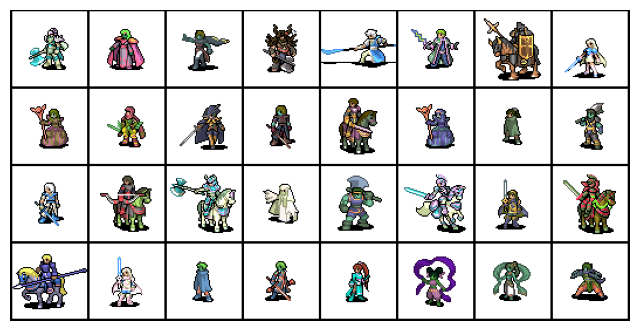

In [23]:
# денормализация для отображения
def denorm(img_batch):
    return (img_batch * 0.5) + 0.5  # [-1,1] -> [0,1]

grid = vutils.make_grid(denorm(images[:32]), nrow=8, padding=2)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

## Конфигурация датасета и сохранение мэппингов

Зафиксируем:
- списки классов (`gender_classes`, `hero_classes`, `palette_classes`)
- размерность условного вектора `cond_dim`
и сохраним их в JSON, чтобы в коде модели не зависеть от ноутбука.

In [24]:
cond_dim = len(gender_classes) + len(hero_classes) + len(palette_classes)
print("cond_dim:", cond_dim)

dataset_config = {
    "image_size": 64,
    "channels": 3,
    "cond_dim": cond_dim,
    "num_gender_classes": len(gender_classes),
    "num_hero_classes": len(hero_classes),
    "num_palette_classes": len(palette_classes),
}

label_mappings = {
    "gender_classes": gender_classes,
    "gender_to_idx": gender_to_idx,
    "hero_classes": hero_classes,
    "hero_to_idx": hero_to_idx,
    "palette_classes": palette_classes,
    "palette_to_idx": palette_to_idx,
}

with open(DATA_DIR / "dataset_config.json", "w", encoding="utf-8") as f:
    json.dump(dataset_config, f, ensure_ascii=False, indent=2)

with open(DATA_DIR / "label_mappings.json", "w", encoding="utf-8") as f:
    json.dump(label_mappings, f, ensure_ascii=False, indent=2)

dataset_config

cond_dim: 16


{'image_size': 64,
 'channels': 3,
 'cond_dim': 16,
 'num_gender_classes': 2,
 'num_hero_classes': 9,
 'num_palette_classes': 5}